In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

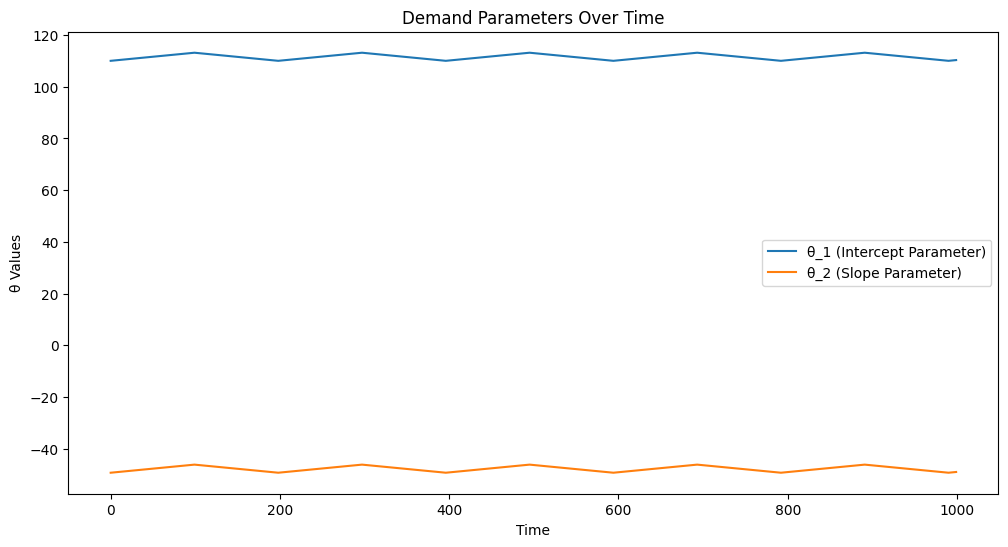

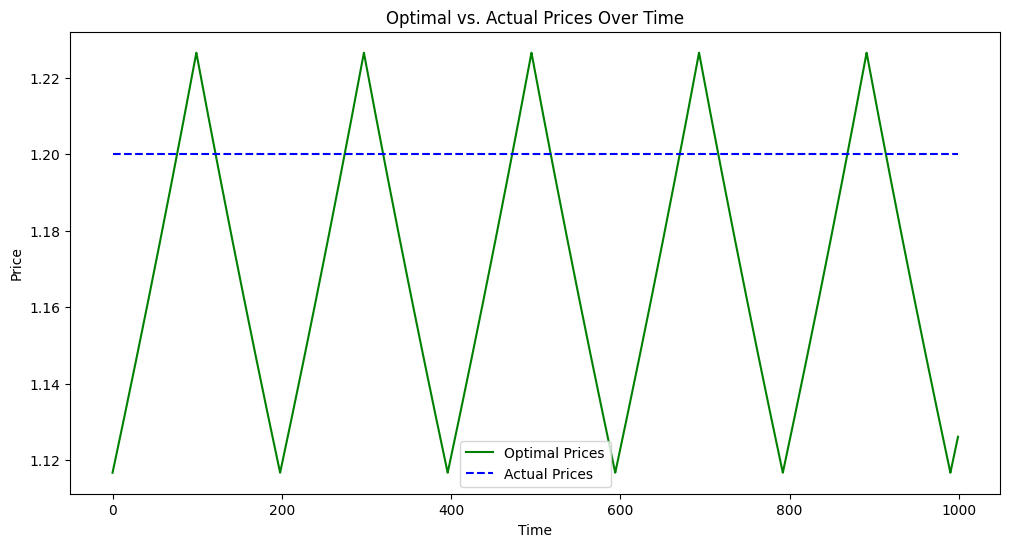

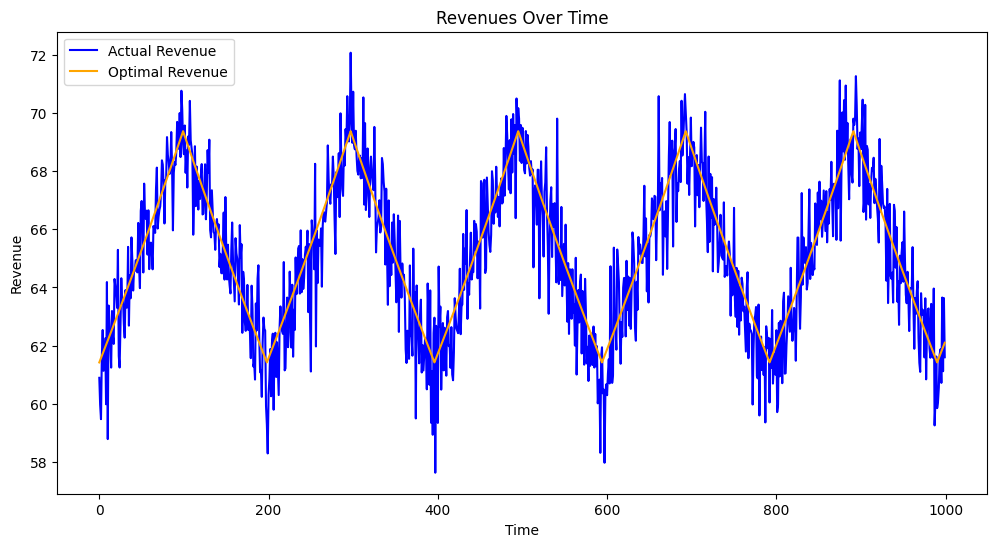

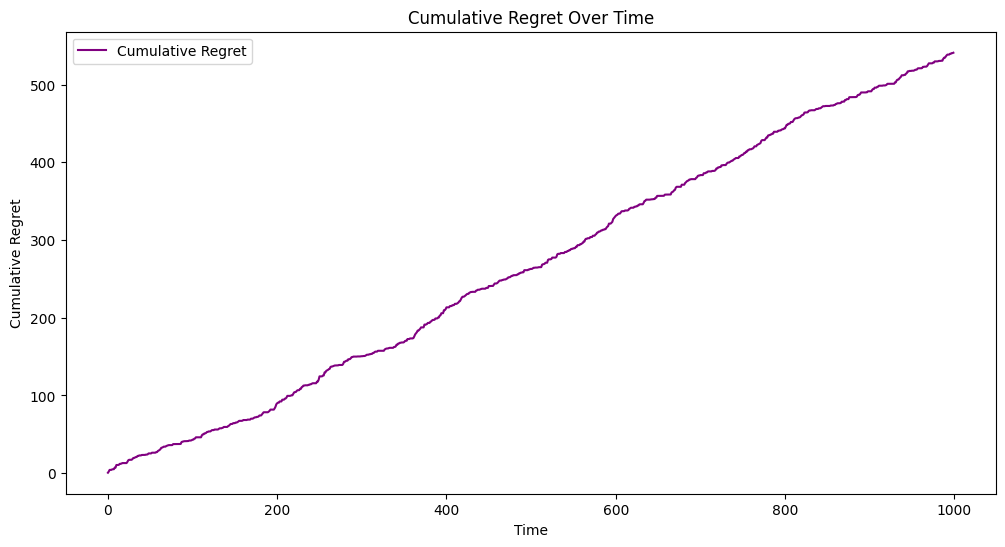

In [2]:
# Parameters
T = 1000  # Time horizon
K = int(T ** (2 / 3))  # Cyclical threshold
sigma = 1  # Standard deviation of demand shocks
price_range = (0.9, 1.8)  # Feasible price range

# Feasible ranges for demand parameters
theta1_range = (100, 120)  # Range for θ1
theta2_range = (-50, -35)  # Range for θ2

# Initial demand parameters
theta_t = np.array([110, -49.25])

# Storage for demand parameters, prices, demands, revenues, regrets
theta_sequence = []
prices = []
demands = []
optimal_prices = []
actual_revenues = []
optimal_revenues = []
regrets = []
cumulative_regrets = []

# Generate the demand parameter sequence
for t in range(T):
    theta_sequence.append(theta_t.copy())

    # Update both θ1 and θ2
    if (t % (2 * K)) < K:
        delta_theta = np.array([T ** (-0.5), T ** (-0.5)])  # Positive update
    else:
        delta_theta = np.array([-T ** (-0.5), -T ** (-0.5)])  # Negative update
    theta_t += delta_theta

    # Enforce feasibility bounds for both parameters
    theta_t[0] = np.clip(theta_t[0], theta1_range[0], theta1_range[1])  # θ1 bound
    theta_t[1] = np.clip(theta_t[1], theta2_range[0], theta2_range[1])  # θ2 bound

theta_sequence = np.array(theta_sequence)

# Simulate demand and calculate optimal prices
def demand_function(price, theta, noise=True):
    noise_term = np.random.normal(0, sigma) if noise else 0
    return theta[0] + theta[1] * price + noise_term

cumulative_regret = 0
for t in range(T):
    theta_t = theta_sequence[t]

    # Calculate the optimal price
    optimal_price = -theta_t[0] / (2 * theta_t[1])
    optimal_price = np.clip(optimal_price, price_range[0], price_range[1])  # Constrain to feasible range
    optimal_prices.append(optimal_price)

    # Optimal revenue (deterministic demand)
    optimal_demand = demand_function(optimal_price, theta_t, noise=False)  # Deterministic
    optimal_revenue = optimal_price * optimal_demand
    optimal_revenues.append(optimal_revenue)

    # Actual revenue
    price = 1.2
    demand = demand_function(price, theta_t, noise=True)  # Stochastic
    actual_revenue = price * demand
    actual_revenues.append(actual_revenue)

    # Calculate regret (non-negative)
    regret = max(0, optimal_revenue - actual_revenue)
    regrets.append(regret)

    # Calculate cumulative regret
    cumulative_regret += regret
    cumulative_regrets.append(cumulative_regret)

    # Save results
    prices.append(price)
    demands.append(demand)

# Plot the demand parameters over time
plt.figure(figsize=(12, 6))
plt.plot(theta_sequence[:, 0], label="θ_1 (Intercept Parameter)")
plt.plot(theta_sequence[:, 1], label="θ_2 (Slope Parameter)")
plt.title("Demand Parameters Over Time")
plt.xlabel("Time")
plt.ylabel("θ Values")
plt.legend()
plt.show()

# Plot the optimal and actual prices over time (overlayed)
plt.figure(figsize=(12, 6))
plt.plot(optimal_prices, label="Optimal Prices", color="green")
plt.plot(prices, label="Actual Prices", color="blue", linestyle="--")
plt.title("Optimal vs. Actual Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot the revenues
plt.figure(figsize=(12, 6))
plt.plot(actual_revenues, label="Actual Revenue", color="blue")
plt.plot(optimal_revenues, label="Optimal Revenue", color="orange")
plt.title("Revenues Over Time")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.legend()
plt.show()


# Plot the cumulative regret
plt.figure(figsize=(12, 6))
plt.plot(cumulative_regrets, label="Cumulative Regret", color="purple")
plt.title("Cumulative Regret Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.show()


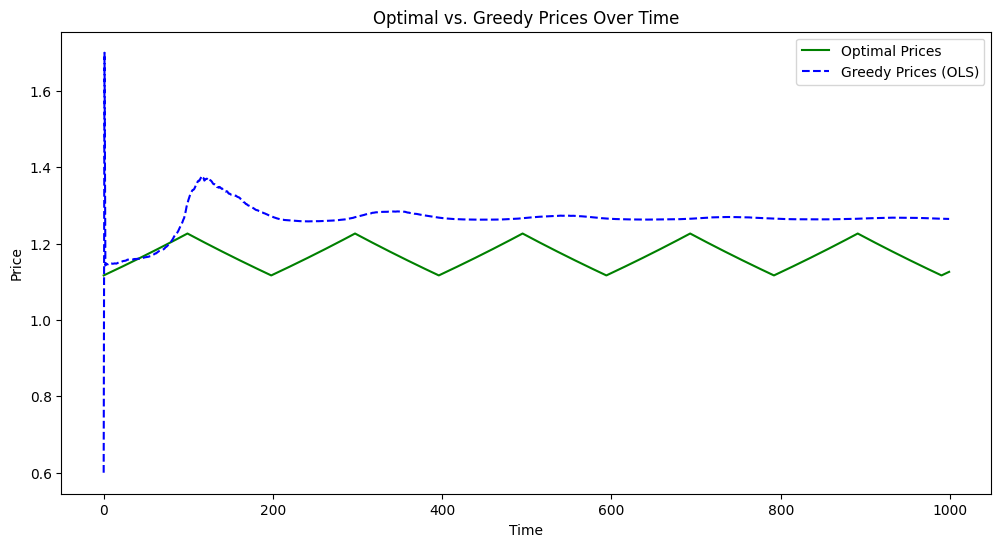

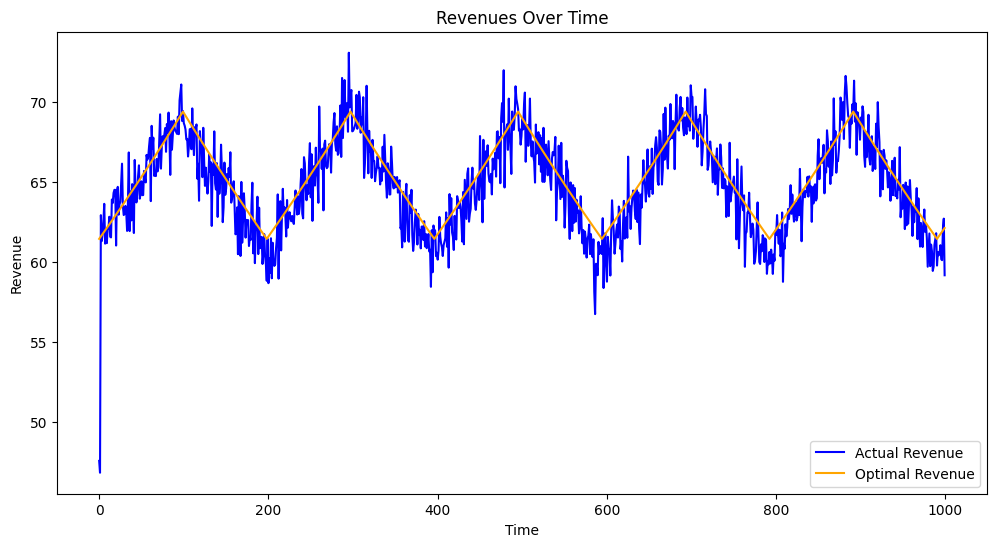

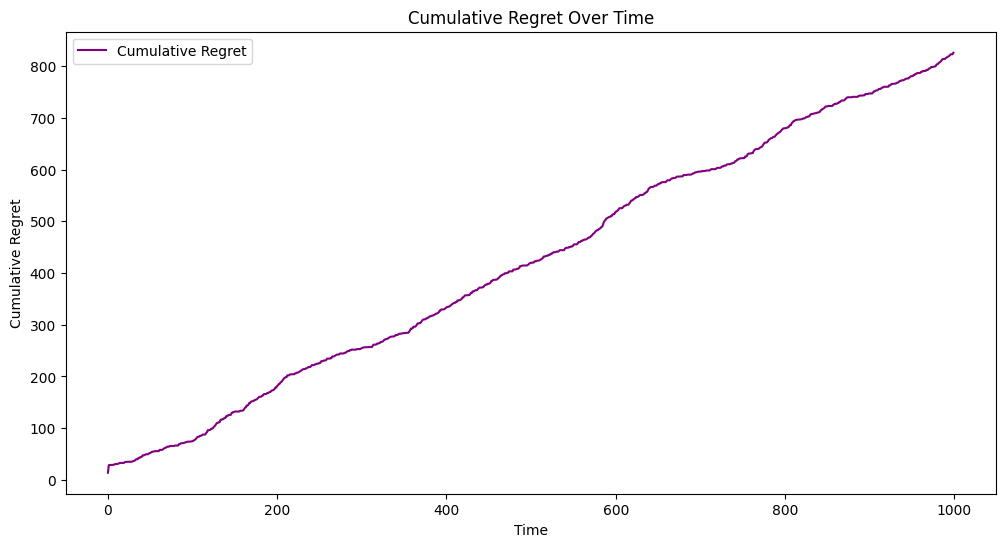

In [3]:
# Greedy Price
# Parameters
T = 1000  # Time horizon
sigma = 1  # Standard deviation of demand shocks
price_range = (0.9, 1.8)  # Feasible price range

# Feasible ranges for demand parameters
theta1_range = (100, 120)  # Range for θ1
theta2_range = (-50, -35)  # Range for θ2

# Initial demand parameters
theta_t = np.array([110, -49.25])

# Storage for demand parameters, prices, demands, revenues, regrets
theta_sequence = []
prices = []
demands = []
optimal_prices = []
actual_revenues = []
optimal_revenues = []
regrets = []
cumulative_regrets = []

# Initialize arrays for OLS estimation
past_prices = []
past_demands = []

# Generate the demand parameter sequence
K = int(T ** (2 / 3))  # Cyclical threshold
for t in range(T):
    theta_sequence.append(theta_t.copy())

    # Update both θ1 and θ2
    if (t % (2 * K)) < K:
        delta_theta = np.array([T ** (-0.5), T ** (-0.5)])  # Positive update
    else:
        delta_theta = np.array([-T ** (-0.5), -T ** (-0.5)])  # Negative update
    theta_t += delta_theta

    # Enforce feasibility bounds for both parameters
    theta_t[0] = np.clip(theta_t[0], theta1_range[0], theta1_range[1])  # θ1 bound
    theta_t[1] = np.clip(theta_t[1], theta2_range[0], theta2_range[1])  # θ2 bound

theta_sequence = np.array(theta_sequence)

# Simulate demand and calculate optimal prices
def demand_function(price, theta, noise=True):
    noise_term = np.random.normal(0, sigma) if noise else 0
    return theta[0] + theta[1] * price + noise_term

cumulative_regret = 0
for t in range(T):
    theta_t = theta_sequence[t]

    # Calculate the optimal price
    optimal_price = -theta_t[0] / (2 * theta_t[1])
    optimal_price = np.clip(optimal_price, price_range[0], price_range[1])  # Constrain to feasible range
    optimal_prices.append(optimal_price)

    # Optimal revenue (deterministic demand)
    optimal_demand = demand_function(optimal_price, theta_t, noise=False)  # Deterministic
    optimal_revenue = optimal_price * optimal_demand
    optimal_revenues.append(optimal_revenue)

    # Set prices for the first two periods
    if t == 0:
        price = 0.6 #price_range[0]  # First price (e.g., lower bound)
    elif t == 1:
        price = 1.7 #price_range[1]  # Second price (e.g., upper bound)
    else:
        # OLS estimation of demand parameters
        X = np.column_stack((np.ones(len(past_prices)), past_prices))  # Design matrix
        y = np.array(past_demands)  # Observed demands
        theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)  # OLS estimate

        # Calculate greedy price
        estimated_theta1, estimated_theta2 = theta_hat
        price = -estimated_theta1 / (2 * estimated_theta2)  # Revenue-maximizing price
        price = np.clip(price, price_range[0], price_range[1])  # Constrain to feasible range


    # Actual revenue (stochastic demand)
    demand = demand_function(price, theta_t, noise=True)  # Stochastic
    actual_revenue = price * demand
    actual_revenues.append(actual_revenue)

    # Calculate regret (non-negative)
    regret = max(0, optimal_revenue - actual_revenue)
    regrets.append(regret)

    # Calculate cumulative regret
    cumulative_regret += regret
    cumulative_regrets.append(cumulative_regret)

    # Save prices and demands
    prices.append(price)
    demands.append(demand)

    # Update past prices and demands
    past_prices.append(price)
    past_demands.append(demand)

# Plot the optimal and greedy prices over time (overlayed)
plt.figure(figsize=(12, 6))
plt.plot(optimal_prices, label="Optimal Prices", color="green")
plt.plot(prices, label="Greedy Prices (OLS)", color="blue", linestyle="--")
plt.title("Optimal vs. Greedy Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot the revenues
plt.figure(figsize=(12, 6))
plt.plot(actual_revenues, label="Actual Revenue", color="blue")
plt.plot(optimal_revenues, label="Optimal Revenue", color="orange")
plt.title("Revenues Over Time")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.legend()
plt.show()

# Plot the cumulative regret
plt.figure(figsize=(12, 6))
plt.plot(cumulative_regrets, label="Cumulative Regret", color="purple")
plt.title("Cumulative Regret Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.show()

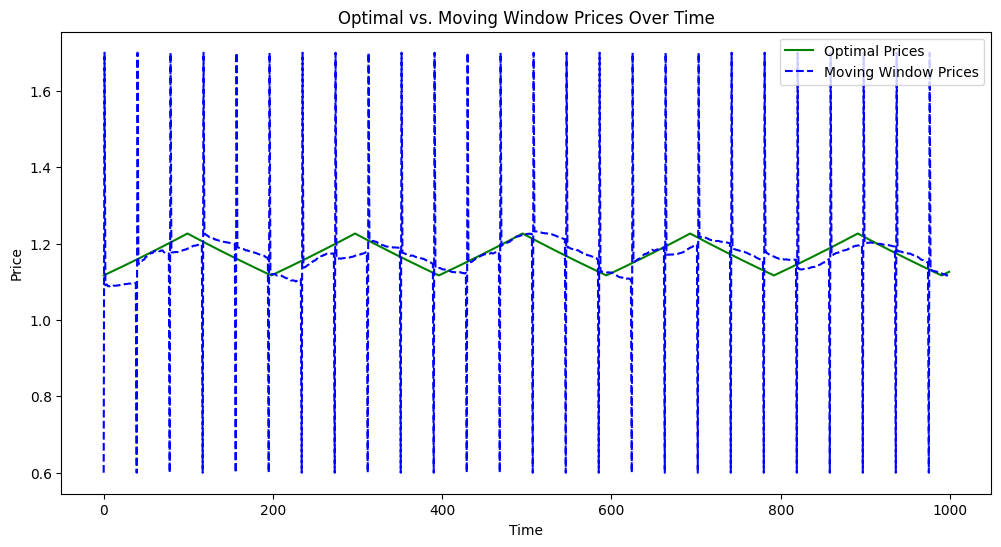

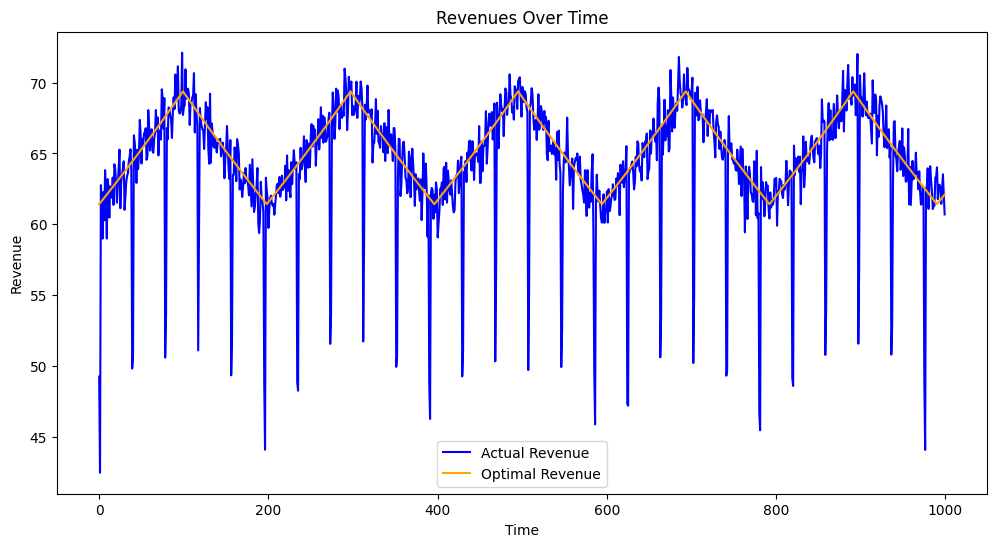

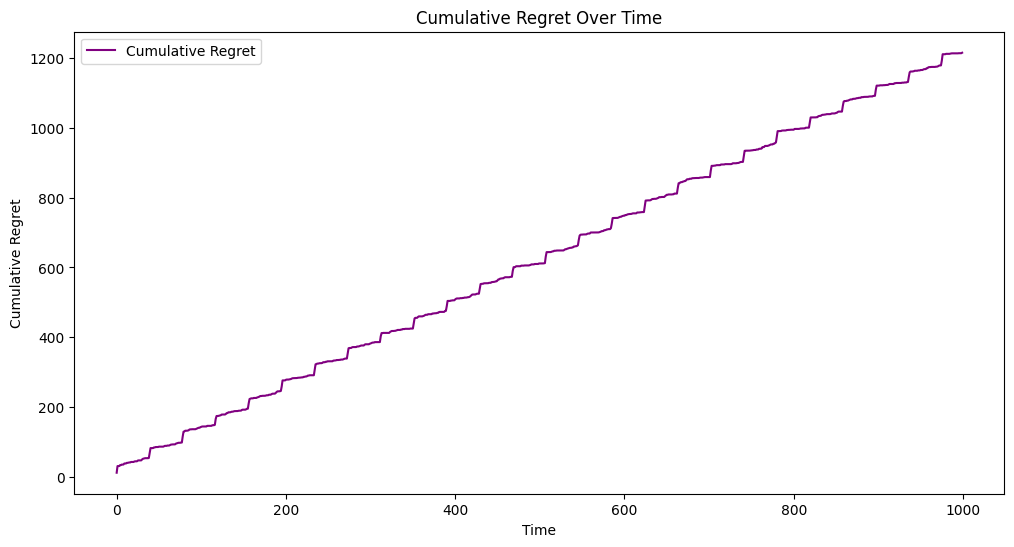

In [4]:
#Moving Window

import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1000  # Time horizon
sigma = 1  # Standard deviation of demand shocks
price_range = (0.8, 1.8)  # Feasible price range
κ = 4  # Frequency of price tests
x1 = 0.6  # Test price 1
x2 = 1.7  # Test price 2
n = int(np.floor(κ * T ** (1 / 3)))  # Number of periods for price tests

# Feasible ranges for demand parameters
theta1_range = (100, 120)  # Range for θ1
theta2_range = (-50, -35)  # Range for θ2

# Initial demand parameters
theta_t = np.array([110, -49.25])

# Storage for demand parameters, prices, demands, revenues, regrets
theta_sequence = []
prices = []
demands = []
optimal_prices = []
actual_revenues = []
optimal_revenues = []
regrets = []
cumulative_regrets = []

# Initialize arrays for OLS estimation
past_prices = []
past_demands = []

# Generate the demand parameter sequence
K = int(T ** (2 / 3))  # Cyclical threshold
for t in range(T):
    theta_sequence.append(theta_t.copy())

    # Update both θ1 and θ2
    if (t % (2 * K)) < K:
        delta_theta = np.array([T ** (-0.5), T ** (-0.5)])  # Positive update
    else:
        delta_theta = np.array([-T ** (-0.5), -T ** (-0.5)])  # Negative update
    theta_t += delta_theta

    # Enforce feasibility bounds for both parameters
    theta_t[0] = np.clip(theta_t[0], theta1_range[0], theta1_range[1])  # θ1 bound
    theta_t[1] = np.clip(theta_t[1], theta2_range[0], theta2_range[1])  # θ2 bound

theta_sequence = np.array(theta_sequence)

# Simulate demand and calculate optimal prices
def demand_function(price, theta, noise=True):
    noise_term = np.random.normal(0, sigma) if noise else 0
    return theta[0] + theta[1] * price + noise_term

# Define the Moving Window Policy
def moving_window_policy(t, past_prices, past_demands, x1, x2, n):
    # Determine the price for the current period
    if t % n == 0:  # Price x1 is tested
        return x1
    elif t % n == 1:  # Price x2 is tested
        return x2
    else:
        # Use OLS estimation with the data from the moving window
        if len(past_prices) > n:
            past_prices = past_prices[-n:]  # Keep only the most recent n observations
            past_demands = past_demands[-n:]

        X = np.column_stack((np.ones(len(past_prices)), past_prices))  # Design matrix
        y = np.array(past_demands)  # Observed demands
        theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)  # OLS estimate

        # Calculate the price based on OLS estimates
        estimated_theta1, estimated_theta2 = theta_hat
        price = -estimated_theta1 / (2 * estimated_theta2)  # Revenue-maximizing price
        price = np.clip(price, price_range[0], price_range[1])  # Constrain to feasible range
        return price

# Simulate the pricing process
cumulative_regret = 0
for t in range(T):
    theta_t = theta_sequence[t]

    # Calculate the optimal price
    optimal_price = -theta_t[0] / (2 * theta_t[1])
    optimal_price = np.clip(optimal_price, price_range[0], price_range[1])  # Constrain to feasible range
    optimal_prices.append(optimal_price)

    # Optimal revenue (deterministic demand)
    optimal_demand = demand_function(optimal_price, theta_t, noise=False)  # Deterministic
    optimal_revenue = optimal_price * optimal_demand
    optimal_revenues.append(optimal_revenue)

    # Get price from the moving window policy
    price = moving_window_policy(t, past_prices, past_demands, x1, x2, n)

    # Actual revenue (stochastic demand)
    demand = demand_function(price, theta_t, noise=True)  # Stochastic
    actual_revenue = price * demand
    actual_revenues.append(actual_revenue)

    # Calculate regret (non-negative)
    regret = max(0, optimal_revenue - actual_revenue)
    regrets.append(regret)

    # Calculate cumulative regret
    cumulative_regret += regret
    cumulative_regrets.append(cumulative_regret)

    # Save prices and demands
    prices.append(price)
    demands.append(demand)

    # Update past prices and demands for OLS in the next period
    past_prices.append(price)
    past_demands.append(demand)

# Plot the optimal and greedy prices over time (overlayed)
plt.figure(figsize=(12, 6))
plt.plot(optimal_prices, label="Optimal Prices", color="green")
plt.plot(prices, label="Moving Window Prices", color="blue", linestyle="--")
plt.title("Optimal vs. Moving Window Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
#plt.xlim(0, 100)
plt.legend()
plt.show()

# Plot the revenues
plt.figure(figsize=(12, 6))
plt.plot(actual_revenues, label="Actual Revenue", color="blue")
plt.plot(optimal_revenues, label="Optimal Revenue", color="orange")
plt.title("Revenues Over Time")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.legend()
plt.show()

# Plot the cumulative regret
plt.figure(figsize=(12, 6))
plt.plot(cumulative_regrets, label="Cumulative Regret", color="purple")
plt.title("Cumulative Regret Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.show()